# Text Analysis and Visualization Notebook

This notebook processes a CSV file containing text data, cleans the text by removing markdown formatting and URLs, filters out non-Tagalog or Taglish text based on a specified confidence threshold, and visualizes the results. The goal is to identify and analyze Filipino phrases in the dataset.


In [1]:
# Import necessary libraries
import pandas as pd
from lingua import Language, LanguageDetectorBuilder  # Placeholder for actual import if using a different library
from markdown import Markdown
from io import StringIO
import re
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Configuration

Set the path to the CSV file and the threshold for identifying Tagalog content.

In [5]:
# Configuration variables
CSV_FILENAME = 'testing.csv'  # Path to the CSV file
TAGALOG_THRESHOLD = 0.5  # Threshold for Tagalog content detection

# Read the CSV file into a pandas DataFrame
csv_data = pd.read_csv(CSV_FILENAME)

## Text Processing Functions

Define functions to clean the text data by removing markdown formatting, URLs, and Reddit usernames.

In [3]:
# Function to convert markdown formatted text to plain text
def unmark_element(element, stream=None):
    if stream is None:
        stream = StringIO()
    if element.text:
        stream.write(element.text)
    for sub in element:
        unmark_element(sub, stream)
    if element.tail:
        stream.write(element.tail)
    return stream.getvalue()

# Patching the Markdown library to add a plain text output format
Markdown.output_formats["plain"] = unmark_element
__md = Markdown(output_format="plain")
__md.stripTopLevelTags = False

# Wrapper function to convert markdown text to plain text
def unmark(text):
    return __md.convert(text)

# Function to remove URLs from a text string and replace them with '[LINK]'
def remove_urls(text):
    url_pattern = re.compile(r'http\S+', re.IGNORECASE)
    return url_pattern.sub('[LINK]', text)

# Function to remove Reddit usernames from a text string and replace them with '[USERNAME]'
def remove_usernames(text):
    username_pattern = re.compile(r"/?u/[A-Za-z0-9_-]+", re.IGNORECASE)
    return username_pattern.sub('[USERNAME]', text)

## Count Before Filtering
Start by capturing the count of rows in your DataFrame before applying any filters:

In [6]:
# Count the number of rows before filtering
count_before_filtering = len(csv_data)

print(f"Count before filtering: {count_before_filtering}")

Count before filtering: 9151


## Main Data Processing & Saving Processed Data

Read the CSV file, process the text data, filter based on the Tagalog content threshold, and count the number of Filipino phrases identified. Save the filtered and processed data to a new CSV file.


In [7]:
if __name__ == "__main__":
    # Ensure the Tagalog threshold is within the valid range
    if not (0.00 <= TAGALOG_THRESHOLD <= 1.00):
        print("ERROR: Tagalog threshold must be between 0.0 and 1.0")
        exit(1)

    # Initialize the language detector with the specified languages
    languages = [Language.ENGLISH, Language.TAGALOG]
    detector = LanguageDetectorBuilder.from_languages(*languages).build()

    # Read the CSV file
    try:
        csv_data = pd.read_csv(CSV_FILENAME, lineterminator='\n')
    except FileNotFoundError:
        print("ERROR: File not found")
        exit(1)

    # Drop unnecessary columns
    csv_data = csv_data.drop(columns=['id', 'subreddit', 'author', 'score', 'timestamp', 'Unnamed: 0'])

    # Add a blank 'label' column for annotation
    csv_data['label'] = ''

    filipino_phrases = 0  # Counter for Filipino phrases
    for row in csv_data.itertuples():  # Iterate over each row in the CSV
        text = str(row.body)  # Convert to string to handle non-string data

        # Clean the text by removing markdown, URLs, & usernames
        text = unmark(text)
        text = remove_urls(text)
        text = remove_usernames(text)

        # Compute the confidence of the text being Tagalog
        result = detector.compute_language_confidence(text, Language.TAGALOG)
        
        # If the confidence is above the threshold, consider it a Filipino phrase
        if result >= TAGALOG_THRESHOLD:
            filipino_phrases += 1
            csv_data.at[row.Index, 'body'] = text  # Update the text in the CSV
        else:
            csv_data.drop(row.Index, inplace=True)  # Drop rows that don't meet the threshold

    print(f"Total: {filipino_phrases}")  # Print the total number of Filipino phrases found

    # Save the filtered CSV
    filtered_filename = CSV_FILENAME.replace('.csv', '-filtered.csv')
    csv_data.to_csv(filtered_filename, index=False)  # Prevent index from being saved as a column

    print(f"Filtered data saved to {filtered_filename}")

Total: 2716
Filtered data saved to testing-filtered.csv


## Count After Filtering
After filtering, capture the count of rows in your DataFrame again:

In [8]:
# Count the number of rows after filtering
count_after_filtering = len(csv_data)  # Assuming csv_data now contains the filtered data

print(f"Count after filtering: {count_after_filtering}")

Count after filtering: 2716


## Visualization of Filtering Effect

To understand the impact of our filtering based on the Tagalog content threshold, we will visualize the number of comments in the dataset before and after the filtering process. This will help us gauge the extent of data reduction and ensure that the filtering aligns with our expectations.

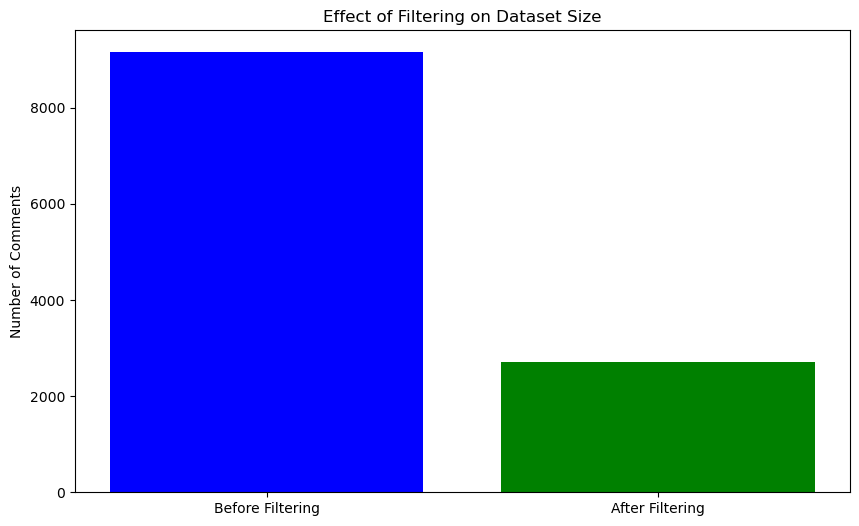

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(['Before Filtering', 'After Filtering'], [count_before_filtering, count_after_filtering], color=['blue', 'green'])
plt.title('Effect of Filtering on Dataset Size')
plt.ylabel('Number of Comments')
plt.show()